In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
import pickle
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 

3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [58]:
# gdf = gpd.read_file("../CA/contours-iris.gpkg")
# gdf = gdf.to_crs(epsg=4326)
# gdf["fid"] = gdf.index
# gdf["lon"] = gdf.geometry.centroid.x
# gdf["lat"] = gdf.geometry.centroid.y
# gdf = gdf.sort_values(by="code_iris")
# with open("gdf.pickle", "wb") as f:
#     pickle.dump(gdf, f)
with open("gdf.pickle", "rb") as f:
     gdf_france = pickle.load(f)

In [303]:
spe_df = pd.read_sql("select id, label_long label from specialite", config.connection_string, index_col="id")
spe_df.T

id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
label,Psychiatre,Anesthésiste,Dermatologue,Gastro-entérologue,Gynécologue,Opthtalmogue,Pédiatre,Radiologue,Dentiste,Généraliste,Cardiologue,Chirugien,Endocrinologue,Gériatre,Neurologue,Oto-rhino-laryngologiste,Pneumologue,Radiothérapeuthe,Rhumatologue,Stomatologue


In [308]:
code_commune = "06088" #"75101" #"75056" #"69123" #"38185"  #"06088" "38205" "2A004"
specialite = 10
year = 21
source="PA" # PA or PS
time=30 # 30 or 45
time_type="HC" # HC or HP

type_code="COM" # Don't touch
if len(code_commune) != 5:
    type_code="ERROR"
print(f"Type code: {type_code}")

Type code: COM


In [309]:
sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code='{code_commune}'
order by i.id
"""
iris_df = pd.read_sql(sql, config.connection_string)
iriss = iris_df["code"].values
commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
print(f"Found {len(iriss)} iris for {commune_nom}")

Found 146 iris for Nice


In [310]:
if len(iriss)>0:
    gdf = gdf_france[gdf_france["code_iris"].isin(iriss)]
else:
    gdf = gdf_france[gdf_france["code_insee"]==code_commune]
    type_code="INSEE"
    commune_nom=gdf["nom_commune"].iloc[0] if len(gdf) > 0 else None
    print(f"Found {len(gdf)} iris in {commune_nom}")
geojson=gdf.__geo_interface__
print(f"Found {len(gdf)} geo iris for {commune_nom}, type_code: {type_code}")
# gdf_france[gdf_france["nom_commune"].str.startswith("Lyon")].head(100)
gdf.head(2)

Found 146 geo iris for Nice, type_code: COM


,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat
2597,IRIS____0000000060880101,06088,Nice,0101,060880101,Saleya-Château,H,"MULTIPOLYGON (((7.28193 43.69312, 7.28159 43.6...",2597,7.277064,43.695476
4458,IRIS____0000000060880102,06088,Nice,0102,060880102,Vieux Nice-Sainte-Réparate,H,"MULTIPOLYGON (((7.27454 43.69773, 7.27598 43.6...",4458,7.275641,43.697293


In [311]:
sql = f"""
select * from apl.apl_study s
where s.specialite_id={specialite}
and s.year={year}
and s.source='{source}'
and s.time={time}
and s.time_type='{time_type}'
order by date desc
limit 1
"""
study_df = pd.read_sql(sql, config.connection_string)
study_df

,year,specialite_id,source,time,time_type,exp,mean,std,q10,q25,q50,q75,q90,min,max,date,key
0,21,10,PA,30,HC,-0.12,66.239008,36.20015,29.513588,40.432111,56.872725,85.083597,117.776403,0.0,681.212229,2025-10-27 15:23:38.204846,923382762052


In [312]:
key = study_df["key"].iloc[0]
print(f"Study key: {key}")
if type_code == "COM":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and code_commune='{code_commune}'
    """
    apl = pd.read_sql(sql, config.connection_string)
if type_code == "INSEE" or len(apl) == 0:
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    """
    apl = pd.read_sql(sql, config.connection_string)
len(apl)

Study key: 923382762052


146

In [313]:
apl["code_iris"]=apl["iris_string"]
gdf = gdf.merge(apl, on="code_iris", how="left", suffixes=('', '_dest')).copy()
len(gdf)

146

In [314]:
gdf["pretty"]=gdf["apl"].apply(lambda x: round(x, 0))
gdf["pretty"] = gdf["pretty"].astype(np.int32)
gdf["r_pretty"]=gdf["R"].apply(lambda x: round(x, 2))
gdf["popgp_pretty"]=gdf["pop_gp"].apply(lambda x: round(x, 0))
gdf["popgp_pretty"] = gdf["popgp_pretty"].astype(np.int32)

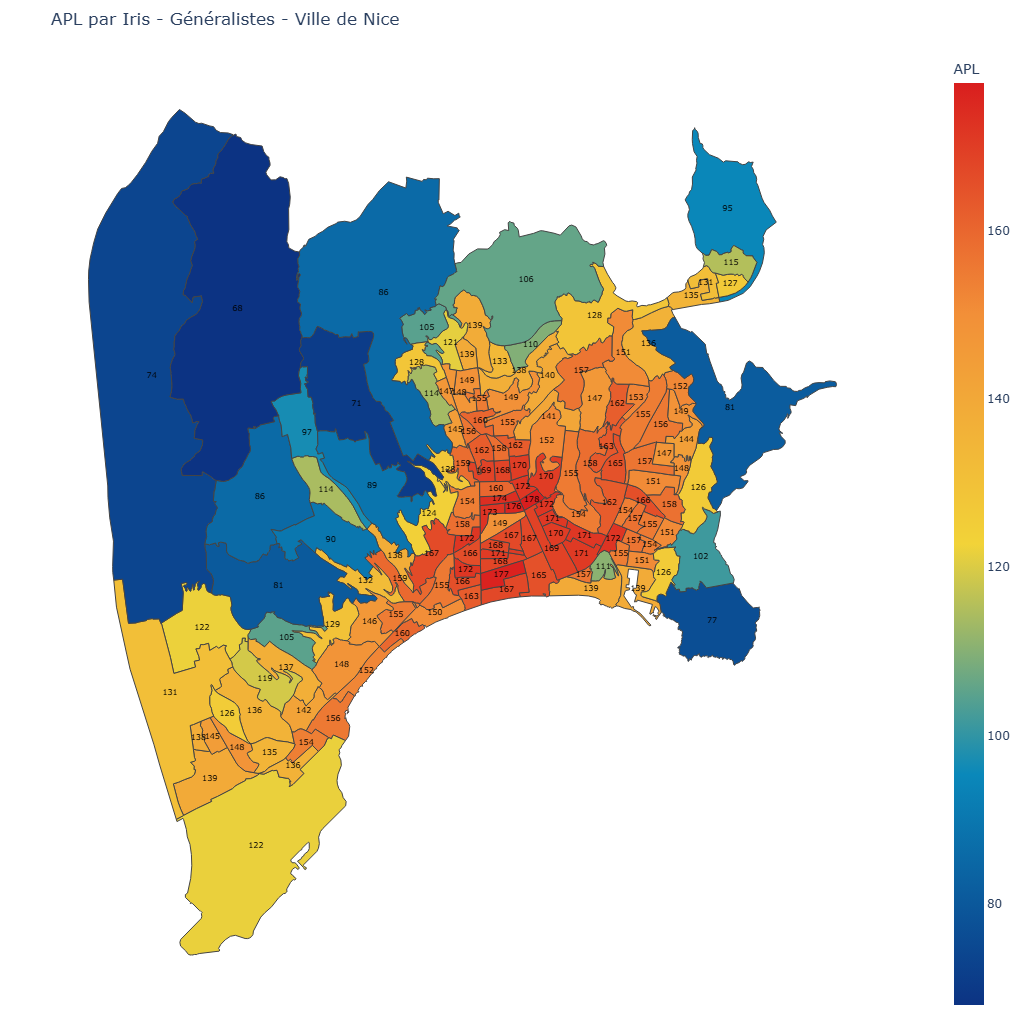

In [315]:
fig = go.Figure()

z_values=gdf["apl"]

fig.add_trace(go.Choropleth(
    geojson=geojson,
    locations=gdf["fid"],
    z=z_values,
    zmin=z_values.min(),
    zmax=z_values.max(),
    text=gdf.apply(
        lambda row: f"Nom: {row['nom_iris']}<br>APL: {row['pretty']}<br>Nb: {row['nb']}<br>PopGP: {row['popgp_pretty']}<br>R: {row['r_pretty']}",
        axis=1
    ),
    hoverinfo="text",
    showscale=True,
    colorscale="Portland",
    colorbar={"title": "APL"}
))
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

fig.add_trace(go.Scattergeo(
    lon=gdf["lon"],
    lat=gdf["lat"],
    text=gdf["pretty"].astype(str),
    mode="text",
    textfont=dict(color="black", size=8),
    hoverinfo="skip",
    showlegend=False,
    marker=dict(
            color='#99ff99',
            size=8,
            line=dict(
                color='#006600',
                width=2
            )
        ),
))
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        center={"lat": center_lat, "lon": center_lon},
        fitbounds="locations",
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        visible=False
    ),
    title=f"APL par Iris - Généralistes - Ville de {commune_nom}",
    height=1000,
    width=1200,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

In [295]:
q0, q10, q25, q50, q75, q90, q100 = np.quantile(gdf["apl"], [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])
q0, q10, q25, q50, q75, q90, q100
gdf["apl"].describe().apply("{0:.0f}".format)

count    146
mean     144
std       25
min       68
25%      132
50%      151
75%      162
max      178
Name: apl, dtype: object

In [137]:
pio.write_html(fig, file="apl_gene.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})